# TalkingData AdTracking Fraud Detection Challenge

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. 
With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. 
Our challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Data Description

Each row of the training data contains a click record, with the following features.

* ip: ip address of click.
* app: app id for marketing.
* device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click (UTC)
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded


Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

* click_id: reference for making predictions
* is_attributed: not included

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,train_test_split
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, classification_report, ConfusionMatrixDisplay                                             
from sklearn.naive_bayes import GaussianNB                         
from imblearn.over_sampling import SMOTE 


import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

### Exploratory Data Analysis 

In [2]:
df=pd.read_parquet('../data/train_sample.parquet')

In [3]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,None,0
1,105560,25,1,17,259,2017-11-07 13:40:27,None,0
2,101424,12,1,19,212,2017-11-07 18:05:24,None,0
3,94584,13,1,13,477,2017-11-07 04:58:08,None,0
4,68413,12,1,1,178,2017-11-09 09:00:09,None,0


In [4]:
df.shape

(100000, 8)

In [5]:
#df[df.device>1].shape

In [6]:
#df[df.device>1][df.is_attributed==1].shape

In [7]:
#df['device'] = (df['device']>=1).astype(int)

In [8]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [9]:
t1 = df.loc[df['is_attributed'] != 0.]
t0 = df.loc[df['is_attributed'] == 0.]


In [10]:
t0.describe()

,ip,app,device,os,channel,is_attributed
count,99773.000000,99773.000000,99773.000000,99773.000000,99773.000000,99773.0
mean,91072.821575,12.001964,21.779860,22.801780,268.976857,0.0
std,69624.459455,14.840636,259.928394,55.828922,129.715348,0.0
min,9.000000,1.000000,0.000000,0.000000,3.000000,0.0
25%,40462.000000,3.000000,1.000000,13.000000,145.000000,0.0
50%,79800.000000,12.000000,1.000000,18.000000,258.000000,0.0
75%,118154.000000,15.000000,1.000000,19.000000,379.000000,0.0
max,364757.000000,551.000000,3867.000000,866.000000,498.000000,0.0


In [11]:
t1.describe()

,ip,app,device,os,channel,is_attributed
count,227.000000,227.000000,227.000000,227.000000,227.000000,227.0
mean,171715.154185,32.229075,17.986784,30.070485,205.365639,1.0
std,106667.455804,33.769395,89.035564,93.414692,117.758991,0.0
min,2948.000000,3.000000,0.000000,0.000000,3.000000,1.0
25%,81155.000000,18.000000,1.000000,13.000000,113.000000,1.0
50%,179080.000000,19.000000,1.000000,19.000000,213.000000,1.0
75%,256782.500000,35.000000,1.000000,24.000000,274.000000,1.0
max,358438.000000,261.000000,957.000000,866.000000,489.000000,1.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [13]:
df.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [14]:
for i in df.columns:
    cnt = len(df[i].unique())
    print(i,":",cnt)

ip : 34857
app : 161
device : 100
os : 130
channel : 161
click_time : 80350
attributed_time : 228
is_attributed : 2


<Figure size 640x480 with 0 Axes>

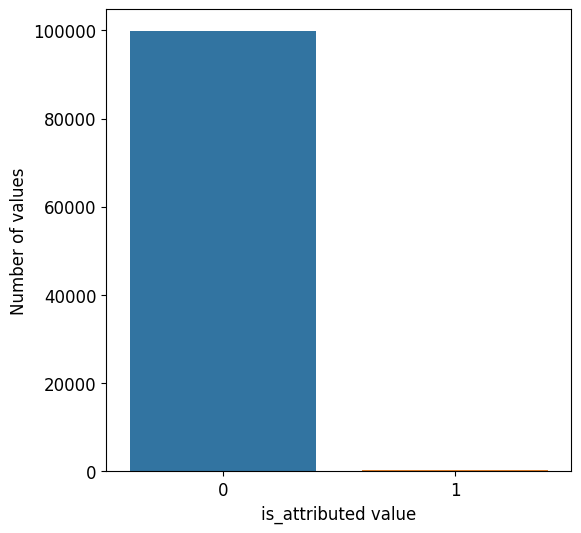

In [15]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = df['is_attributed'].value_counts().index.values
y = df["is_attributed"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('is_attributed value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [16]:
df['year'] = pd.to_datetime(df.click_time).dt.year
df['month'] = pd.to_datetime(df.click_time).dt.month
df['day'] = pd.to_datetime(df.click_time).dt.day
df['hour'] = pd.to_datetime(df.click_time).dt.hour
df['min'] = pd.to_datetime(df.click_time).dt.minute
df['sec'] = pd.to_datetime(df.click_time).dt.second
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,year,month,day,hour,min,sec
0,87540,12,1,13,497,2017-11-07 09:30:38,None,0,2017,11,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,None,0,2017,11,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,None,0,2017,11,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,None,0,2017,11,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,None,0,2017,11,9,9,0,9


In [17]:
df.describe()

,ip,app,device,os,channel,is_attributed,year,month,day,hour,min,sec
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,100000.000000,100000.000000,100000.00000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270,2017.0,11.0,7.861460,9.328590,29.15540,29.779910
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591,0.0,0.0,0.889266,6.180586,17.36966,17.233844
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000,2017.0,11.0,6.000000,0.000000,0.00000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000,2017.0,11.0,7.000000,4.000000,14.00000,15.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000,2017.0,11.0,8.000000,9.000000,29.00000,30.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000,2017.0,11.0,9.000000,14.000000,44.00000,45.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000,2017.0,11.0,9.000000,23.000000,59.00000,59.000000


<AxesSubplot:xlabel='day', ylabel='count'>

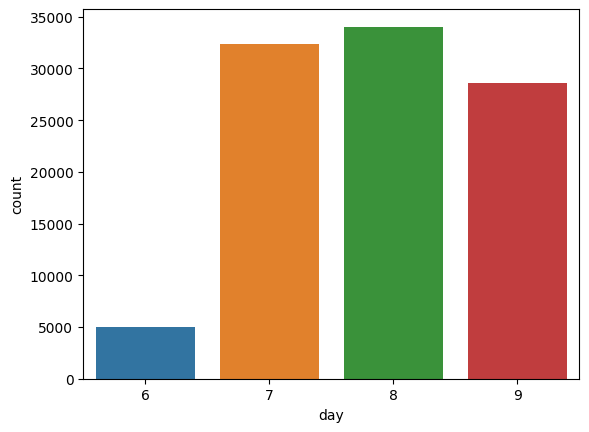

In [20]:
sns.countplot(x=df['day'])

<AxesSubplot:xlabel='hour', ylabel='count'>

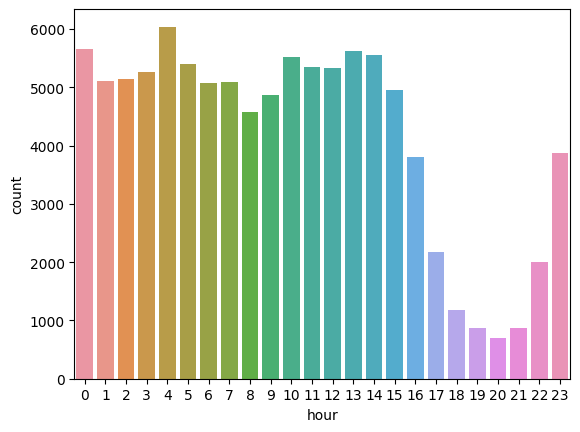

In [21]:
sns.countplot(x=df['hour'])

<AxesSubplot:>

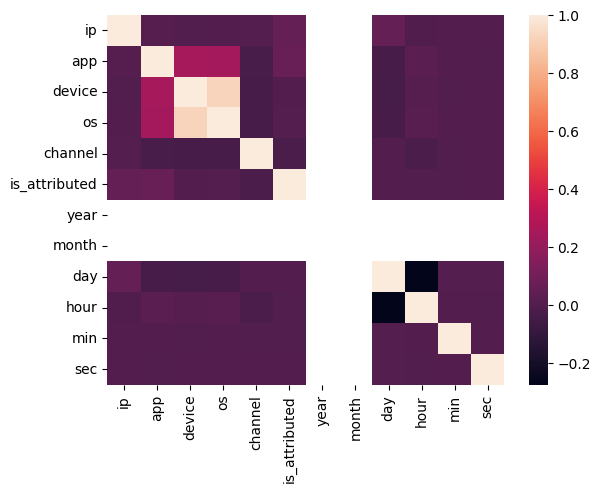

In [118]:
corr_matrix=df.corr()
 
#Creating a seaborn heatmap
sns.heatmap(corr_matrix)

### Feature Engineering 

#### Handling missing values

In [119]:
df.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
year                   0
month                  0
day                    0
hour                   0
min                    0
sec                    0
dtype: int64

In [120]:
df=df.drop(["attributed_time"], axis=1)

In [121]:
df['click_time'].min(),df['click_time'].max()

('2017-11-06 16:00:00', '2017-11-09 15:59:51')

In [122]:
df.isnull().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
year             0
month            0
day              0
hour             0
min              0
sec              0
dtype: int64

In [123]:
df

,ip,app,device,os,channel,click_time,is_attributed,year,month,day,hour,min,sec
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017,11,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2017,11,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017,11,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017,11,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017,11,9,9,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0,2017,11,9,13,25,41
99996,85150,9,1,13,244,2017-11-07 11:25:43,0,2017,11,7,11,25,43
99997,18839,3,1,13,19,2017-11-08 11:38:42,0,2017,11,8,11,38,42
99998,114276,15,1,12,245,2017-11-08 17:55:21,0,2017,11,8,17,55,21


In [124]:
df=df.drop(["click_time","year","month","day","sec"], axis=1)

In [125]:
df

,ip,app,device,os,channel,is_attributed,hour,min
0,87540,12,1,13,497,0,9,30
1,105560,25,1,17,259,0,13,40
2,101424,12,1,19,212,0,18,5
3,94584,13,1,13,477,0,4,58
4,68413,12,1,1,178,0,9,0
...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,0,13,25
99996,85150,9,1,13,244,0,11,25
99997,18839,3,1,13,19,0,11,38
99998,114276,15,1,12,245,0,17,55


In [126]:
X=df.drop("is_attributed",axis=1)
y=df[["is_attributed"]]

In [127]:
X

,ip,app,device,os,channel,hour,min
0,87540,12,1,13,497,9,30
1,105560,25,1,17,259,13,40
2,101424,12,1,19,212,18,5
3,94584,13,1,13,477,4,58
4,68413,12,1,1,178,9,0
...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,13,25
99996,85150,9,1,13,244,11,25
99997,18839,3,1,13,19,11,38
99998,114276,15,1,12,245,17,55


In [128]:
y

,is_attributed
0,0
1,0
2,0
3,0
4,0
...,...
99995,0
99996,0
99997,0
99998,0


In [129]:
x_train,x_test,y_train,y_test=train_test_split(X,y,
                             test_size=0.25,
                             random_state=100)

In [130]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(75000, 7)
(25000, 7)
(75000, 1)
(25000, 1)


In [131]:
print(y_train.mean())
print(y_test.mean())

is_attributed    0.00216
dtype: float64
is_attributed    0.0026
dtype: float64


#### Oversampling

In [298]:
train_data=x_train.copy()
train_data['is_attributed']=y_train

In [294]:
def oversampling(data,n):
    for i in range(n):
        data=pd.concat([data,data.query('is_attributed==1')])
    return data

In [301]:
train_data=oversampling(train_data,4)

In [302]:
train_data.shape

(77430, 8)

In [140]:
x_train1=train_data.drop("is_attributed",axis=1)
y_train1=train_data[["is_attributed"]]

In [325]:
def report(model,x_test,y_test):
    y_pred=model.predict(x_test)
    print("confusion matrix is :\n " ,metrics.confusion_matrix(y_test,y_pred))
    print("\n\nf1 score is :",metrics.f1_score(y_test,y_pred,average='macro'))
    print("\n\nrecall score is :",metrics.recall_score(y_test,y_pred))
    return

In [326]:
report(XGB_model1,x_test,y_test)

confusion matrix is :
  [[24911    24]
 [    0    65]]


f1 score is : 0.9218371805941521


recall score is : 1.0


### Logistic regression 

In [146]:
from sklearn.linear_model import LogisticRegression

In [156]:
log_reg=LogisticRegression()
log_reg.fit(x_train1,y_train1)

/opt/anaconda3/envs/project/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [327]:
report(log_reg,x_test,y_test)

confusion matrix is :
  [[24895    40]
 [   57     8]]


f1 score is : 0.5698242630113969


recall score is : 0.12307692307692308


###  XGBoost

In [264]:
XGB_model1 = XGBClassifier(n_estimators=800,max_depth=10)
XGB_model1.fit(x_train1,y_train1)


### Random forest classifier 

In [268]:
rfc=RandomForestClassifier(n_estimators=800,max_depth=12)

In [269]:
rfc.fit(x_train1,y_train1)

/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(max_depth=12, n_estimators=800)

In [328]:
report(rfc,x_test,y_test)

confusion matrix is :
  [[24917    18]
 [   11    54]]


f1 score is : 0.8938697871584198


recall score is : 0.8307692307692308
